## Cross-Sell Prediction
Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarant

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) et

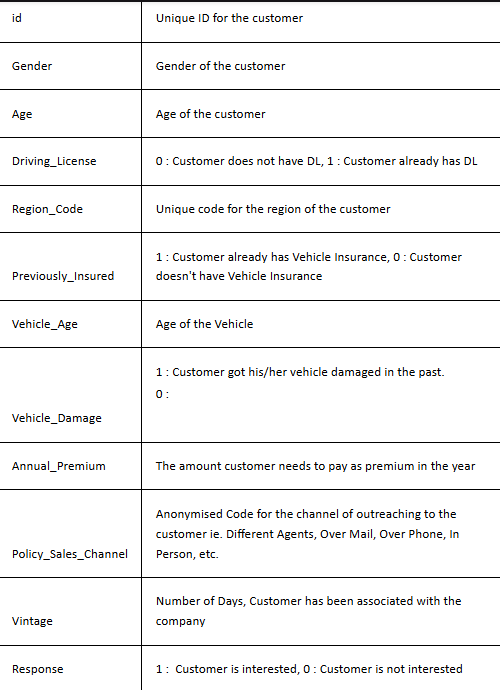c.ee.

In [1]:
# load the importemt libraries to the norebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data into the note book
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission_iA3afxn.csv')

In [3]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


In [4]:
test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199


In [6]:
# assigning a varible for target column and ignore columns 

tgt_col =['Response']
ign_col = ['id']
cat_col = train.select_dtypes(include='object').columns
num_col = train.select_dtypes(include='number').drop(columns=ign_col+tgt_col).columns

In [7]:
print(tgt_col)
print(ign_col)
print(cat_col)
print(num_col)

['Response']
['id']
Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


# Building machine learning pipeline 

In [14]:
train['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

# the data is imbalanced so need balance the data with oversampling, undersampling and SMOT techniques

In [17]:
# install the libraries for working on imbalanced data
!pip install imblearn

In [18]:
# make the copy of the original data 
train_1 = train.copy()
test_2 = test.copy()

In [19]:
# import required librarires for the sampling techniques 
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [20]:
# seperate dependent and independent features fron the dataset
X = train_1.drop(columns = ign_col+tgt_col)
y = train_1[tgt_col]

In [21]:
X.head(2)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183


In [22]:
y.head(2)

,Response
0,1
1,0


# Resampling 

In [24]:
x = train_1.drop(columns = ign_col+tgt_col)
y = train_1[tgt_col]

In [25]:
ros = RandomOverSampler(random_state=0)
X_ros,y_ros= ros.fit_resample(x, y)


In [26]:
y_ros.value_counts()

Response
0           334399
1           334399
Name: count, dtype: int64

# split the data into training and testing data 

In [28]:
train_X, val_X, train_y, val_y = train_test_split(X_ros,y_ros, random_state=42,test_size=0.3)

In [29]:
print(train_X.shape, train_y.shape)
print (val_X.shape, val_y.shape) 

(468158, 10) (468158, 1)
(200640, 10) (200640, 1)


# building machine learning pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score

# import required models
from sklearn.linear_model import LogisticRegression


In [32]:
cat_pipe_encode = Pipeline(
     steps= [
         ('impute_cat', SimpleImputer(strategy='most_frequent')),  #missing value 
         ('ohe', OneHotEncoder(handle_unknown='ignore'))           # categorical encoding
     ]

    
)

In [35]:
num_pipe_encode = Pipeline(
    steps = [
        ('impute_num', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())   #standard scaler
    ]
)

In [40]:
preprocess = ColumnTransformer(
    transformers = [
        ('cat_encode', cat_pipe_encode, cat_col),   # categorical columns 
        ('num_encode', num_pipe_encode, num_col)    # numerical columns
    ]
)

In [42]:
my_model_1 = LogisticRegression()

In [46]:
model_pipeline = Pipeline(
    steps = [
        ('preprocess',preprocess),  # preprocessing
        ('model',my_model_1)           # modeling
    ]
)

In [51]:
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('model', LogisticRegression())])

# making predictions 

In [75]:
def model_train_val_eval(train_X,val_X,train_y,val_y, model_pipeline):
    pred_train = model_pipeline.predict(train_X)
    pred_val = model_pipeline.predict(val_X)

    print("Train Confusion. Matrix : \n",confusion_matrix(train_y, pred_train))
    print("Test Confusion. Matrix  : \n",confusion_matrix(val_y, pred_val))
    print("Train Report : \n",classification_report(train_y, pred_train))
    print("Test Report : \n",classification_report(val_y, pred_val))
    print("TRAIN ROC AUC SCORE  : \n",roc_auc_score(train_y,  pred_train))
    print("Test ROC AUC SCORE  : \n",roc_auc_score(val_y, pred_val)) 
    print('Train F1 score:', f1_score(train_y,pred_train))
    print('val F1 score:', f1_score(val_y,pred_val))

  
    

In [77]:
model_train_val_eval(train_X,val_X,train_y,val_y,model_pipeline)

Train Confusion. Matrix : 
 [[138657  95606]
 [  6344 227551]]
Test Confusion. Matrix  : 
 [[59759 40377]
 [ 2788 97716]]
Train Report : 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73    234263
           1       0.70      0.97      0.82    233895

    accuracy                           0.78    468158
   macro avg       0.83      0.78      0.77    468158
weighted avg       0.83      0.78      0.77    468158

Test Report : 
               precision    recall  f1-score   support

           0       0.96      0.60      0.73    100136
           1       0.71      0.97      0.82    100504

    accuracy                           0.78    200640
   macro avg       0.83      0.78      0.78    200640
weighted avg       0.83      0.78      0.78    200640

TRAIN ROC AUC SCORE  : 
 0.7823813803978696
Test ROC AUC SCORE  : 
 0.7845190959780491
Train F1 score: 0.8169829746594572
val F1 score: 0.8190882534147537


In [80]:
sub['Response']= model_pipeline.predict(test_2)
sub.to_csv('submission1.csv', index=False)

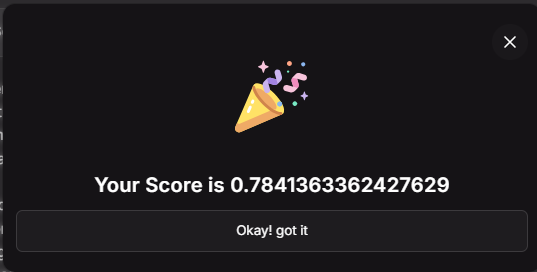

# logistic regression hyper perameter tuning
